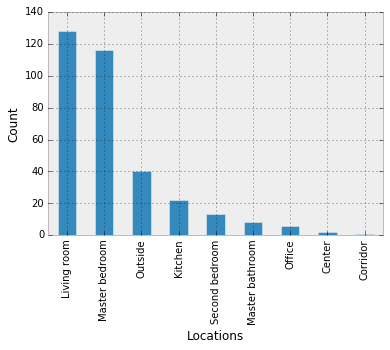

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import seaborn.apionly as sns
import statsmodels.api as sm
import theano.tensor as tt

from sklearn import preprocessing

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']
%run ../Evaluation/LoadAndReduceData.py

In [6]:
dataset.head()

,location,time,day,hour,sep_hour,location_name
0,0,00:00:00,0,0,0,Master bedroom
1,0,00:01:00,0,0,0,Master bedroom
2,0,00:02:00,0,0,0,Master bedroom
3,0,00:03:00,0,0,0,Master bedroom
4,0,00:04:00,0,0,0,Master bedroom


In [7]:
X = reduced_dataset_3readings[['sep_hour']].values
_, num_X = X.shape

with pm.Model() as model:       
    intercept = pm.Normal('intercept', mu=0, sd=100)
    beta_sep_hour = pm.Normal('beta_sep_hour', mu=0, sd=100)
    
    mu = tt.exp(intercept 
                + beta_sep_hour*reduced_dataset_3readings.sep_hour)
    
    y_est = pm.Poisson('y_est', mu=mu, observed=reduced_dataset_3readings['location'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

 [-----------------100%-----------------] 200000 of 200000 complete in 55.0 sec

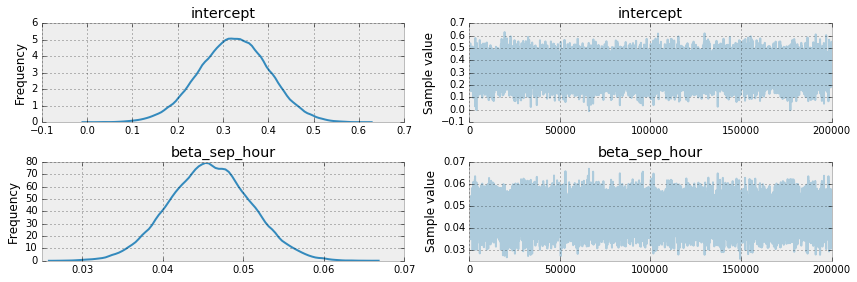

In [8]:
_ = pm.traceplot(trace)

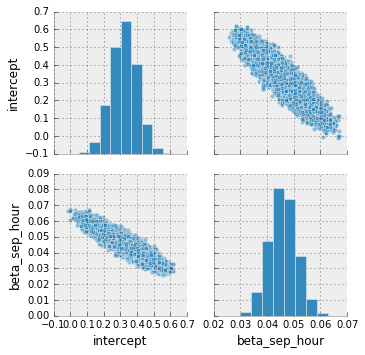

In [9]:
_ = sns.pairplot(pm.trace_to_dataframe(trace[20000:]), plot_kws={'alpha':.5})

In [32]:
reduced_dataset_3readings['location_name'].unique()

array(['Master bedroom', 'Second bedroom', 'Kitchen', 'Living room',
       'Office', 'Outside', 'Center', 'Master bathroom', 'Corridor'], dtype=object)

In [45]:
# Convert categorical variables to integer
#n_locations = reduced_dataset_3readings['location'].unique().size
# Convert categorical variables to integer
le = preprocessing.LabelEncoder()
locations_idx = le.fit_transform(dataset['location_name'])
locations = le.classes_
n_locations = len(locations)
with pm.Model() as model:

    intercept = pm.Normal('intercept', mu=0, sd=100, shape=n_locations)
    slope_time = pm.Normal('slope_time', mu=0, sd=100)
    
    mu = tt.exp(intercept[locations_idx] 
                + slope_time*dataset.sep_hour)
    
    y_est = pm.Poisson('y_est', mu=mu, observed=dataset['location'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

 [                  0%                  ] 791 of 200000 complete in 31.2 sec

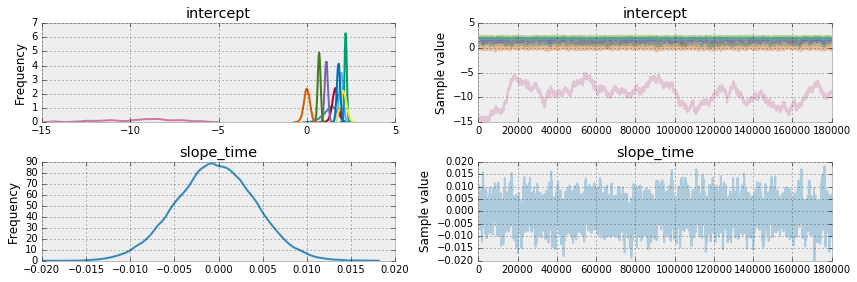

In [43]:
_ = pm.traceplot(trace[20000:])

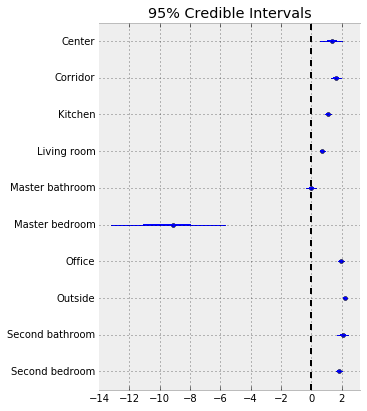

In [44]:
_ = plt.figure(figsize=(5, 6))
_ = pm.forestplot(trace[20000:], varnames=['intercept'], ylabels=locations)

# Von mieses GLM